In [1]:
import random
from functools import partial
import matplotlib
import matplotlib.image as mpimg
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from google.colab import drive
drive.mount('/content/gdrive')
import seaborn as sns
import torch
!pip install torchmetrics
from torchmetrics.functional import f1_score
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=51c2df4b9430ee5e897a126368fbeb6cb75ef06e807d406eb3c2ec116ad23ae5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=1d6bd463685a8d9c5183de55d6ec6537edcc64130cf5bd8ae0cb23c3c5fcf9dc
  Stored in directory: /root/.cache/pi

In [2]:
###
###
# Paths
root_dir = "/content/gdrive/MyDrive/ML/data/augmented4/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth"
test_image_dir = "/content/gdrive/MyDrive/ML/data/test_set_images/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyper parameters
PADDING = 0
EPOCH = 30
BATCH_SIZE = 10
NR_IMAGES = 1200
IMAGE_SIZE = 256

In [4]:
# @title
class PreloadedDataset(Dataset):
    def __init__(self, images, ground_truth):
        self.images = images
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        ground_truth = self.ground_truth[idx]
        return image, ground_truth


def split(dataset, tr,val):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [tr, val])
    return train_dataset, val_dataset

def get_dataloaders(train_dataset, val_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

def load_npy(npy_file_path):
  array = np.load(npy_file_path)
  return array

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def get_image_name(image_dir):
    file_name = os.path.basename(image_dir)
    return file_name

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]

    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def predict_patches(prediction, patch_threshold):
    patches = img_crop(prediction, 16, 16)
    iter = int(np.sqrt(len(patches)))
    results = np.zeros((iter, iter))
    c = 0
    for j in range(iter):
      for i in range(iter):
        if patches[c].mean() > patch_threshold:
          results[i, j] = 1
        c = c + 1
    return results

def masks_to_submission(submission_filename, results):
    """Converts images into a submission file"""
    img_number = 0
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for res in results:
            img_number = img_number + 1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(res, img_number))

def mask_to_submission_strings(result, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = result
    patch_size = 16
    for j in range(0, im.shape[1]):
        for i in range(0, im.shape[0]):
            label = result[i, j]

            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, int(label)))

def write_predictions_to_file(predictions, labels, filename):
    max_labels = np.argmax(labels, 1)
    max_predictions = np.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + " " + max_predictions(i))
    file.close()

def extract_number(folder_name):
    return int(folder_name.split('_')[1])

def compute_f1(res, ans):
    """
    Precision: tp/(tp+fp)
    Recall: tp/(tp+fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    """

    tp = torch.sum((res == 1) & (ans == 1))
    fp = torch.sum((res == 1) & (ans != 1))
    fn = torch.sum((res != 1) & (ans == 1))

    precision = tp / (tp + fp) if (tp + fp) != 0 else torch.tensor(0.0)
    recall = tp / (tp + fn) if (tp + fn) != 0 else torch.tensor(0.0)
    if precision + recall == 0:
        return torch.tensor(0.0)
    else:
        return 2 * (precision * recall) / (precision + recall)


def get_threshold(predictions,labels):
    f1_max = 0
    th = 0

    for t in range(0,100):
        t = t/100
        th_pred = predictions.clone()
        patches = predict_patches(th_pred, t)
        f1 = f1_score(torch.tensor(patches), torch.tensor(labels), task='binary')

        if f1>f1_max:
            f1_max = f1
            th = t
    return th

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()

    # Use tensors for histories
    total_loss = torch.tensor(0.0, device=device)
    total_samples = 0
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)
    batch_iter = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):

        # Prepare batch
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_data)

        # Compute loss
        loss = criterion(output, batch_labels)
        total_loss = total_loss + loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy and F1 per batch
        predictions = (output > 0.3).int()  # Hardcoded threshold
        batch_correct = (predictions == batch_labels).sum()

        batch_accuracy = batch_correct / (batch_labels.shape[0] * batch_labels.shape[1] * batch_labels.shape[2] * batch_labels.shape[3])
        total_accuracy = total_accuracy + batch_accuracy

        total_f1 = total_f1 + f1_score(predictions, batch_labels, task='binary')



        batch_iter = batch_iter + 1




    # Compute averages for the epoch
    epoch_loss = total_loss / batch_iter
    epoch_accuracy = total_accuracy / batch_iter
    epoch_f1 = total_f1 / batch_iter

    # Log the learning rate history
    lr_value = scheduler.get_last_lr()[0]

    print(
        f"Epoch Summary: {epoch} "
        f"Epoch Loss={epoch_loss.item():.3e} "
        f"Accuracy={epoch_accuracy.item():.3f} "
        f"F1={epoch_f1.item():.3e} "
        f"LR={lr_value:.3e}"
    )

    # Return metrics as tensors
    return epoch_loss, epoch_accuracy, lr_value, epoch_f1


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm, etc.)

    # Initialize tensors for aggregating metrics
    total_loss = torch.tensor(0.0, device=device)
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)


    batch_iter = 0
    for data, target in val_loader:
        # Prepare batch

        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)



        # Compute loss
        batch_loss = criterion(output, target)
        total_loss = total_loss +  batch_loss

        # Compute predictions
        probabilities = F.sigmoid(output)
        predictions = (probabilities > 0.3).int()  # Hardcoded threshold
        total_f1 = total_f1 + compute_f1(predictions, target)

        # F1 and accuracy
        batch_correct = (predictions == target).sum()
        batch_accuracy = batch_correct / (target.shape[0] * target.shape[1] * target.shape[2] * target.shape[3])

        total_accuracy = total_accuracy + batch_accuracy




        batch_iter = batch_iter + 1

    # Compute averages
    avg_loss = total_loss / batch_iter
    avg_accuracy = total_accuracy / batch_iter
    avg_f1 = total_f1 / batch_iter

    # Print validation summary
    print(
        f"Validation Set: Average Loss: {avg_loss.item():.4f}, "
        f"Accuracy: {avg_accuracy.item() * 100:.2f}%, "
        f"F1: {avg_f1.item():.4f}, "
    )

    # Return metrics as tensors
    return avg_loss, avg_f1, avg_accuracy * 100


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",

):
    # ===== Data Loading =====
    train_loader, val_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    # model.apply(init_weights)
    #optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)
    # criterion = DiceLoss()
    criterion = segmentation_models_pytorch.losses.DiceLoss("binary")
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []
    train_f1_history = []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss, train_acc, lrs, f1_hist = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.append(train_loss.detach())
        train_acc_history.append(train_acc)
        lr_history.append(lrs)

        val_loss, f1, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss.detach())
        val_f1_history.append(f1)
        val_acc_history.append(val_acc)
        train_f1_history.append(f1_hist)
        scheduler.step(train_loss)

    return train_loss_history, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history

def remove_islands(prediction):
    prediction = torch.tensor(prediction)
    kernel = torch.ones((1, 1, 3, 3), dtype=prediction.dtype)
    pred = torch.unsqueeze(prediction, dim=0)
    neighbor_count = F.conv2d(pred, kernel, padding=1)
    mask = (prediction == 1) & (neighbor_count == 1)
    prediction = prediction.squeeze()
    mask = mask.reshape((38,38))
    prediction[mask] = 0
    prediction = prediction.reshape((38,38))
    return prediction

def make_preds(model, test_data, threshold):

    model.eval()
    predictions_raw = []
    predictions_no_islands = []
    predictions = []

    island_masks = []
    c = 0
    prob_maps = []

    for i in range(len(test_images)):

      c = c + 1
      print(c)

      # Get model output
      image = torch.tensor(test_images[i]).to(device).permute(2,0,1)
      image = image.unsqueeze(0)
      output = model(image.float())
      output = (torch.squeeze(output) > .5).to(torch.float16)

      prediction = predict_patches(output, threshold)
      predictions_raw.append(prediction)
      prob_map = output.cpu().detach().numpy().astype(np.float32)
      prob_maps.append(prob_map)

      # Removing Islands
      prediction_no_island = remove_islands(prediction)
      predictions_no_islands.append(prediction_no_island.cpu().detach().numpy())
      pred_tensor = torch.tensor(np.array(predictions_no_islands))
    return pred_tensor, prob_maps


In [5]:
# model_names = ['UnetPreTrained','Unet_RN50', 'Unet_RN34', 'Unet_MN']


models = {
     'UnetPreTrained': Unet(
         encoder_name="vgg11",        # Choose encoder
         encoder_weights="imagenet",    # Use pre-trained ImageNet weights
         classes=1,                     # Number of output classes
         activation=None),
            'Unet_RN50': Unet(
        encoder_name="resnet50",        # Choose encoder
        encoder_weights="imagenet",    # Use pre-trained ImageNet weights
        classes=1,                     # Number of output classes
        activation=None),
             'Unet_RN34': Unet(
         encoder_name="resnet34",        # Choose encoder
         encoder_weights="imagenet",    # Use pre-trained ImageNet weights
         classes=1,                     # Number of output classes
         activation=None),
         "Unet_MN": Unet(
         encoder_name="mobilenet_v2",        # Choose encoder
         encoder_weights=None,    # Use pre-trained ImageNet weights
         classes=1,                     # Number of output classes
         activation=None)
        }






Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:02<00:00, 185MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


In [ ]:

test_folders = sorted(os.listdir(test_image_dir), key = extract_number)

test_images = []
for folder in test_folders:
  image_name = sorted(os.listdir(test_image_dir + folder))[0]
  print(image_name)
  image_path = test_image_dir + folder + '/' + image_name
  image = load_image(image_path)
  test_images.append(image)

In [16]:
for model in models:
  models[model].load_state_dict(torch.load(f"/content/gdrive/MyDrive/ML/models/{model}_1_base_case_1800_im.pth", map_location=torch.device('cpu')))

<ipython-input-16-8fa0fbdfc8db>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[model].load_state_dict(torch.load(f"/content/gdrive/MyDrive/ML/models/{model}_1_base_

In [52]:
SUBMISSION_NAME = 'U_NETs_1_1900_30_epochs_.40_crf.csv'

In [ ]:
thresholds = [.3, .3, .3, .3]

preds = {}
for i, model_name in enumerate(models):
  pred = make_preds(models[model_name].to("cuda"), test_images, thresholds[i])
  preds[model_name] = pred

In [31]:
model_names = ['UnetPreTrained','Unet_RN50', 'Unet_RN34', 'Unet_MN']

# predsum = (preds[model_names[0]][1] + preds[model_names[1]][1] + preds[model_names[2]][1] + preds[model_names[3]][1])/4
predtens = dict()
for pred in preds:
  predtens[pred] = torch.tensor(preds[pred][1])

predtens['UnetPreTrained'].shape




torch.Size([50, 608, 608])

In [32]:
predsum = (predtens[model_names[0]] + predtens[model_names[1]] + predtens[model_names[2]] + predtens[model_names[3]])/4


In [54]:
threshold = .4
print(predsum.shape)
patch_ens = [predict_patches(predsum[i], threshold) for i in range(predsum.shape[0])]

torch.Size([50, 608, 608])


torch.Size([50, 38, 38])
UnetPreTrained 92193.0
torch.Size([50, 38, 38])
Unet_RN50 85092.0
torch.Size([50, 38, 38])
Unet_RN34 93565.0
torch.Size([50, 38, 38])
Unet_MN 90991.0


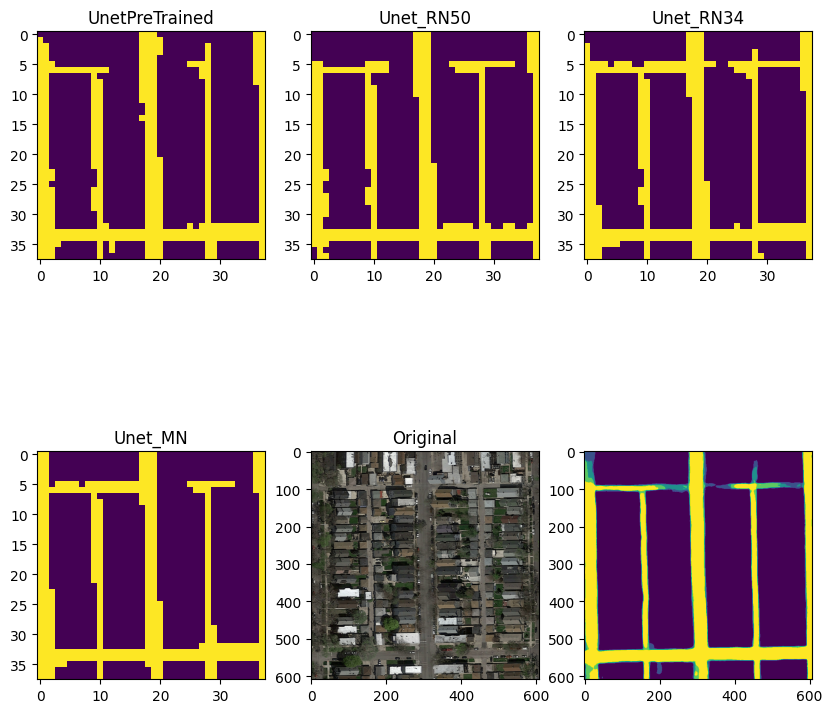

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(10,10))
i = 5
for j, pred in enumerate(preds):
  print(preds[pred][0].shape)
  print(pred, preds[pred][1][i].sum())
  axs[j // 3, j % 3].imshow(preds[pred][0][i])
  axs[j // 3, j % 3].set_title(pred)
axs[1, 1].imshow(test_images[i])
axs[1, 2].imshow(predsum[i])


axs[1, 1].set_title("Original")
plt.show()


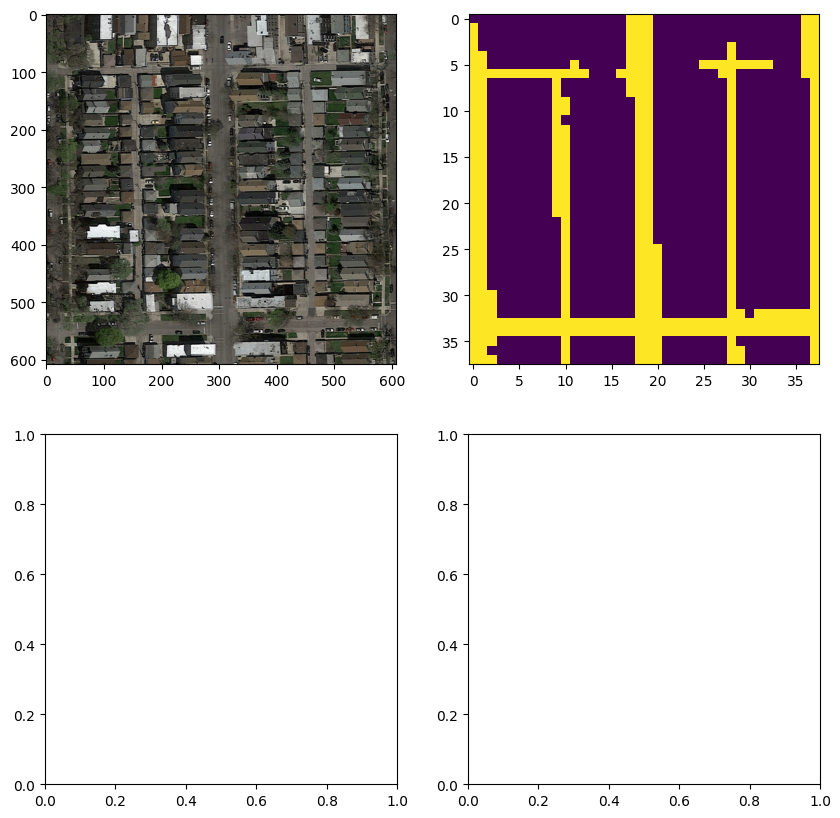

In [48]:
i = 5
fig , axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(test_images[i])
axs[0, 1].imshow(patch_ens[i])

In [55]:
submission_filename = '/content/gdrive/MyDrive/ML/predictions/' + SUBMISSION_NAME
masks_to_submission(submission_filename, patch_ens)